In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from scipy.stats import kurtosis, skew

import eli5
from eli5.sklearn import PermutationImportance

font_path = 'C:/Users/INTEL WIN11PRO(12TH)/anaconda3/Workspace/파이썬데이터분석실습/github프로젝트/fonts/malgun.ttf' 

# 폰트 설정
fontprop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = fontprop.get_name()

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
info = pd.read_csv('data_info.csv')
submission= pd.read_csv('sample_submission.csv')

# EDA

In [3]:
print(train.shape)
print(test.shape)
train.head()

(4701217, 23)
(291241, 22)


,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [4]:
info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

In [6]:
# 컬름이릉 영어에서 한국말로 변역

dictionary = {}
for i in range(24):
    key = info.iloc[i, 0]
    value = info.iloc[i, 1]
    
    dictionary[key] = value
    
train = train.rename(columns = dictionary)
test = test.rename(columns = dictionary)
train.head(5)

,아이디,날짜,요일,시간대,차로수,도로등급,도로명,중용구간 여부,연결로 코드,최고속도제한,...,도로유형,시작지점명,시작지점의 위도,시작지점의 경도,시작 지점의 회전제한 유무,도착지점명,도착지점의 위도,도착지점의 경도,도작지점의 회전제한 유무,평균속도(km)
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [7]:
# nunique 값이랑 dtype을 함께 조회

column_nunique = train.nunique()

for column, unique_count in zip(column_nunique.index, column_nunique.values):
    print(f"Column '{column}' has {unique_count} unique values.")
    
column_info = pd.DataFrame({'nunique': train.nunique(), 'dtype': train.dtypes})
column_info

Column '아이디' has 4701217 unique values.
Column '날짜' has 281 unique values.
Column '요일' has 7 unique values.
Column '시간대' has 24 unique values.
Column '차로수' has 3 unique values.
Column '도로등급' has 3 unique values.
Column '도로명' has 61 unique values.
Column '중용구간 여부' has 2 unique values.
Column '연결로 코드' has 2 unique values.
Column '최고속도제한' has 6 unique values.
Column '통과제한차량' has 1 unique values.
Column '통과제한하중' has 4 unique values.
Column '통과제한높이' has 1 unique values.
Column '도로유형' has 2 unique values.
Column '시작지점명' has 487 unique values.
Column '시작지점의 위도' has 586 unique values.
Column '시작지점의 경도' has 586 unique values.
Column '시작 지점의 회전제한 유무' has 2 unique values.
Column '도착지점명' has 487 unique values.
Column '도착지점의 위도' has 586 unique values.
Column '도착지점의 경도' has 586 unique values.
Column '도작지점의 회전제한 유무' has 2 unique values.
Column '평균속도(km)' has 102 unique values.


,nunique,dtype
아이디,4701217,object
날짜,281,int64
요일,7,object
시간대,24,int64
차로수,3,int64
도로등급,3,int64
도로명,61,object
중용구간 여부,2,int64
연결로 코드,2,int64
최고속도제한,6,float64


In [8]:
# nunique가 10 이하이며 dtype이 object인 칼럼을 category 로 변환

for column in column_info.index:
    if column_info.loc[column, 'nunique'] <= 10 and column_info.loc[column, 'dtype'] == 'object':
        train[column] = train[column].astype('category')

        
# nunique가 5 이하이며 dtype이 int64 혹은 float64인 경우 각각 int8, float16로 변환
for column in column_info.index:
    if column_info.loc[column, 'dtype'] in ['int64', 'float64'] and column_info.loc[column, 'nunique'] <= 5:
        if column_info.loc[column, 'dtype'] == 'int64':
            train[column] = train[column].astype(np.int8)
        else:
            train[column] = train[column].astype(np.float16)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column          Dtype   
---  ------          -----   
 0   아이디             object  
 1   날짜              int64   
 2   요일              category
 3   시간대             int64   
 4   차로수             int8    
 5   도로등급            int8    
 6   도로명             object  
 7   중용구간 여부         int8    
 8   연결로 코드          int8    
 9   최고속도제한          float64 
 10  통과제한차량          float16 
 11  통과제한하중          float16 
 12  통과제한높이          float16 
 13  도로유형            int8    
 14  시작지점명           object  
 15  시작지점의 위도        float64 
 16  시작지점의 경도        float64 
 17  시작 지점의 회전제한 유무  category
 18  도착지점명           object  
 19  도착지점의 위도        float64 
 20  도착지점의 경도        float64 
 21  도작지점의 회전제한 유무   category
 22  평균속도(km)        float64 
dtypes: category(3), float16(3), float64(6), int64(2), int8(5), object(4)
memory usage: 493.2+ MB


## memory usage 820MB --> 493MB

In [10]:
train['시작지점_위경도_벡터'] = np.sqrt(train['시작지점의 위도']**2 + train['시작지점의 경도']**2)
train['도착지점_위경도_벡터'] = np.sqrt(train['도착지점의 위도']**2 + train['도착지점의 경도']**2)

test['시작지점_위경도_벡터'] = np.sqrt(test['시작지점의 위도']**2 + test['시작지점의 경도']**2)
test['도착지점_위경도_벡터'] = np.sqrt(test['도착지점의 위도']**2 + test['도착지점의 경도']**2)

train.drop(['아이디', '시작지점의 위도', '시작지점의 경도','도착지점의 위도','도착지점의 경도'], 
           axis=1, inplace=True)
test.drop(['아이디','시작지점의 위도', '시작지점의 경도','도착지점의 위도','도착지점의 경도'], 
           axis=1, inplace=True)


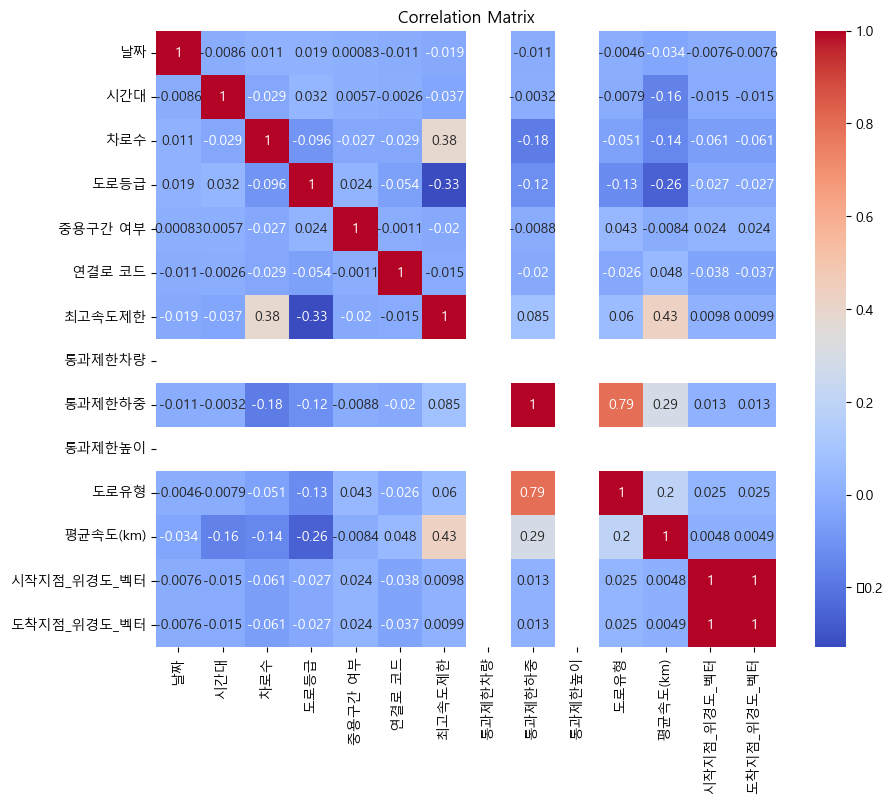

In [11]:
numeric_columns = train.select_dtypes(include='number')

# 상관관계 계산
correlation_matrix = numeric_columns.corr(method = 'pearson')
correlation_matrix

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# object 랑 category 파일을 다 숫자형으로 변환

In [12]:
text_columns = train.select_dtypes(include=['object', 'category'])

In [13]:
text_columns

,요일,도로명,시작지점명,시작 지점의 회전제한 유무,도착지점명,도작지점의 회전제한 유무
0,목,지방도1112호선,제3교래교,없음,제3교래교,없음
1,목,일반국도11호선,광양사거리,있음,KAL사거리,없음
2,일,일반국도16호선,창고천교,없음,상창육교,없음
3,금,태평로,남양리조트,없음,서현주택,없음
4,화,일반국도12호선,애월샷시,없음,애월입구,없음
...,...,...,...,...,...,...
4701212,목,-,대림사거리,없음,금덕해운,없음
4701213,목,-,광삼교,없음,광삼교,없음
4701214,월,일반국도12호선,고성교차로,없음,성산교차로,없음
4701215,수,일반국도95호선,제6광령교,없음,관광대학입구,없음


In [14]:
day_mapping = {
    '월': 0,
    '화': 1,
    '수': 2,
    '목': 3,
    '금': 4,
    '토': 5,
    '일': 6
}



# 데이터프레임에서 단일한 '-'을 0으로 바꾸는 함수 정의
def replace_single_dash_with_zero(df):
    return df.replace(r'^-$', 0, regex=True)

# 데이터프레임의 모든 칼럼에 대해 단일한 '-'을 0으로 바꾸기
train = replace_single_dash_with_zero(train)

In [15]:
def label_encode_feature(df, column):
    le = LabelEncoder()
    encoded_feature = le.fit_transform(df[column])
    return encoded_feature

train['시작지점명_encoded'] = label_encode_feature(train, '시작지점명')
test['시작지점명_encoded'] = label_encode_feature(test, '시작지점명')

train['도착지점명_encoded'] = label_encode_feature(train, '도착지점명')
test['도착지점명_encoded'] = label_encode_feature(test, '도착지점명')

train['시작 지점의 회전제한 유무_encoded'] = label_encode_feature(train, '시작 지점의 회전제한 유무')
test['시작 지점의 회전제한 유무_encoded'] = label_encode_feature(test, '시작 지점의 회전제한 유무')

train['도작지점의 회전제한 유무_encoded'] = label_encode_feature(train, '도작지점의 회전제한 유무')
test['도작지점의 회전제한 유무_encoded'] = label_encode_feature(test, '도작지점의 회전제한 유무')

In [16]:
train.head()

,날짜,요일,시간대,차로수,도로등급,도로명,중용구간 여부,연결로 코드,최고속도제한,통과제한차량,...,시작 지점의 회전제한 유무,도착지점명,도작지점의 회전제한 유무,평균속도(km),시작지점_위경도_벡터,도착지점_위경도_벡터,시작지점명_encoded,도착지점명_encoded,시작 지점의 회전제한 유무_encoded,도작지점의 회전제한 유무_encoded
0,20220623,목,17,1,106,지방도1112호선,0,0,60.0,0.0,...,없음,제3교래교,없음,52.0,130.999357,130.999090,386,386,0,0
1,20220728,목,21,2,103,일반국도11호선,0,0,60.0,0.0,...,있음,KAL사거리,없음,30.0,130.888937,130.887210,32,2,1,0
2,20211010,일,7,2,103,일반국도16호선,0,0,80.0,0.0,...,없음,상창육교,없음,61.0,130.677175,130.671173,426,179,0,0
3,20220311,금,13,2,107,태평로,0,0,50.0,0.0,...,없음,서현주택,없음,20.0,130.860839,130.859764,58,203,0,0
4,20211005,화,8,2,103,일반국도12호선,0,0,80.0,0.0,...,없음,애월입구,없음,38.0,130.683271,130.686870,267,269,0,0


In [17]:
train.drop(['시작지점명','도착지점명', '시작 지점의 회전제한 유무',
            '도작지점의 회전제한 유무', '도로명'], 
           axis=1, inplace=True)
test.drop(['시작지점명','도착지점명', '시작 지점의 회전제한 유무',
            '도작지점의 회전제한 유무', '도로명'], 
           axis=1, inplace=True)

In [18]:
train_x = train.drop(columns=['평균속도(km)'])
train_y = train['평균속도(km)']
test_x = test

## 월별

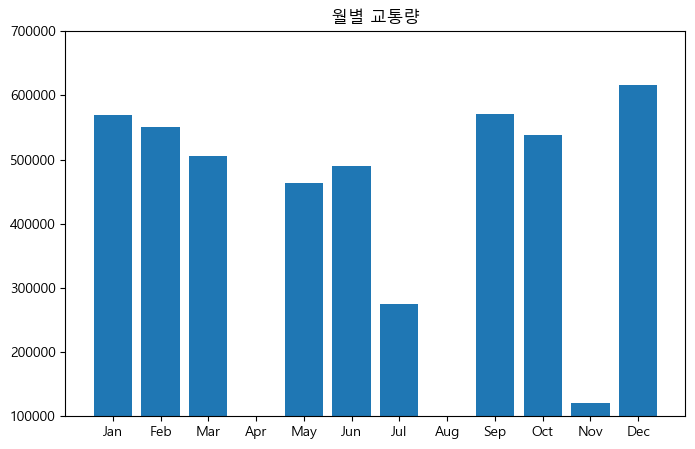

In [19]:
Jan = train[train['날짜'].astype(str).str[:6] == '202201']
Feb = train[train['날짜'].astype(str).str[:6] == '202202']
Mar = train[train['날짜'].astype(str).str[:6] == '202203']
Apr = train[train['날짜'].astype(str).str[:6] == '202204']
May = train[train['날짜'].astype(str).str[:6] == '202205']
Jun = train[train['날짜'].astype(str).str[:6] == '202206']
Jul = train[train['날짜'].astype(str).str[:6] == '202207']
Aug = train[train['날짜'].astype(str).str[:6] == '202108']
Sep = train[train['날짜'].astype(str).str[:6] == '202109']
Oct = train[train['날짜'].astype(str).str[:6] == '202110']
Nov = train[train['날짜'].astype(str).str[:6] == '202111']
Dec = train[train['날짜'].astype(str).str[:6] == '202112']

# 데이터프레임에 월 컬럼 생성
Jan['월'] = "Jan"
Feb['월'] = "Feb"
Mar['월'] = "Mar"
Apr['월'] = "Apr"
May['월'] = "May"
Jun['월'] = "Jun"
Jul['월'] = "Jul"
Aug['월'] = "Aug"
Sep['월'] = "Sep"
Oct['월'] = "Oct"
Nov['월'] = "Nov"
Dec['월'] = "Dec"

# 월별 데이터에 대한 새로운 데이터프레임 생성
month_data = pd.concat([Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec])

# 월별 재정렬을 위해 리스트 생성
month_list=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# 재정렬 후 그룹화해서 갯수 파악
month_sum = month_data.groupby('월')['평균속도(km)'].count().reindex(month_list)
month_sum

# 월별 재정렬한 상태에서 막대그래프 시각화 ( 4월, 8월 데이터 X)
plt.figure(figsize=(8,5))
plt.bar(month_sum.index, month_sum)
plt.title('월별 교통량')
plt.ylim(bottom=100000, top=700000);
plt.show()

## 요일별

In [20]:
train.head()

,날짜,요일,시간대,차로수,도로등급,중용구간 여부,연결로 코드,최고속도제한,통과제한차량,통과제한하중,통과제한높이,도로유형,평균속도(km),시작지점_위경도_벡터,도착지점_위경도_벡터,시작지점명_encoded,도착지점명_encoded,시작 지점의 회전제한 유무_encoded,도작지점의 회전제한 유무_encoded
0,20220623,목,17,1,106,0,0,60.0,0.0,32400.0,0.0,3,52.0,130.999357,130.999090,386,386,0,0
1,20220728,목,21,2,103,0,0,60.0,0.0,0.0,0.0,0,30.0,130.888937,130.887210,32,2,1,0
2,20211010,일,7,2,103,0,0,80.0,0.0,0.0,0.0,0,61.0,130.677175,130.671173,426,179,0,0
3,20220311,금,13,2,107,0,0,50.0,0.0,0.0,0.0,0,20.0,130.860839,130.859764,58,203,0,0
4,20211005,화,8,2,103,0,0,80.0,0.0,0.0,0.0,0,38.0,130.683271,130.686870,267,269,0,0


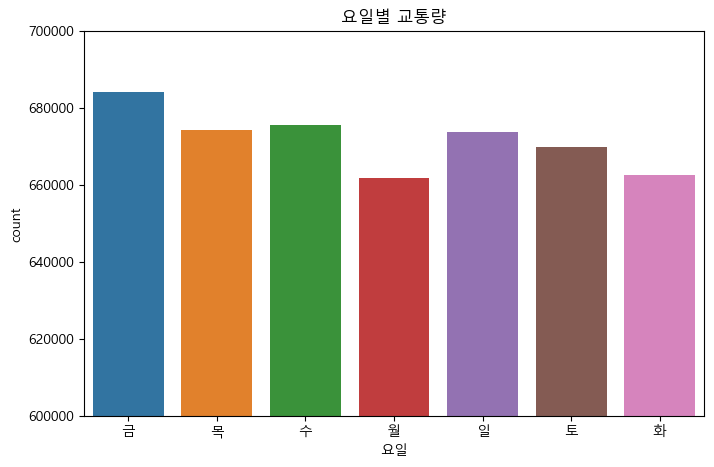

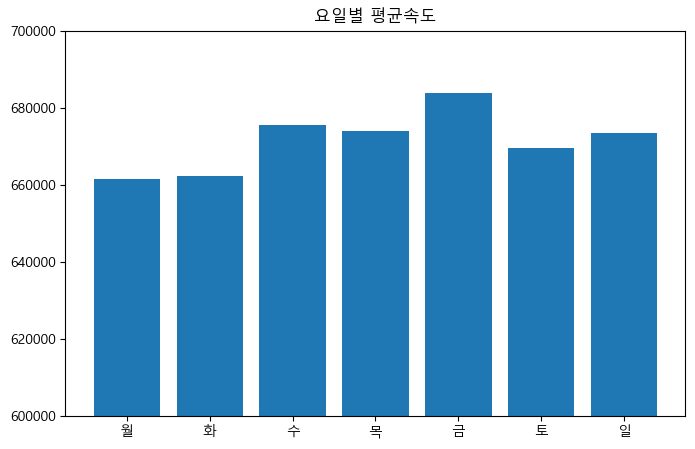

In [21]:
train.dtypes

fig, dayplot = plt.subplots(figsize = (8,5), dpi = 100)
dayplot = sns.countplot(x = '요일', data=train)
dayplot.set_ylim(bottom=600000, top=700000)
dayplot.set_title('요일별 교통량')



# 요일을 정렬하기위해 weeks 리스트 생성
weeks = ['월','화','수','목','금','토','일']

# 집계를 위해 그룹화로 row count
week_sum = train.groupby('요일')['평균속도(km)'].count().reindex(weeks)
week_sum

# 요일을 재정렬한 상태에서 막대그래프 시각화
plt.figure(figsize=(8,5))
plt.bar(week_sum.index, week_sum)
plt.title('요일별 평균속도')
plt.ylim(bottom=600000, top=700000);
plt.show()

In [22]:
# "요일" 변수를 수치형으로 변환
train['요일_숫자형'] = train['요일'].map(day_mapping)
test['요일_숫자형'] = test['요일'].map(day_mapping)
train['요일_숫자형'] = train['요일_숫자형'].astype('int32')


# ' 요일' 칼럼 삭제
train.drop(['요일'], 
           axis=1, inplace=True)
test.drop(['요일'], 
           axis=1, inplace=True)

## 시간대별

0시의 평균 속도는 48.742 km 입니다.
1시의 평균 속도는 49.763 km 입니다.
2시의 평균 속도는 50.279 km 입니다.
3시의 평균 속도는 50.543 km 입니다.
4시의 평균 속도는 49.748 km 입니다.
5시의 평균 속도는 47.201 km 입니다.
6시의 평균 속도는 45.549 km 입니다.
7시의 평균 속도는 43.682 km 입니다.
8시의 평균 속도는 41.656 km 입니다.
9시의 평균 속도는 40.876 km 입니다.
10시의 평균 속도는 40.222 km 입니다.
11시의 평균 속도는 39.825 km 입니다.
12시의 평균 속도는 39.839 km 입니다.
13시의 평균 속도는 39.731 km 입니다.
14시의 평균 속도는 39.561 km 입니다.
15시의 평균 속도는 39.352 km 입니다.
16시의 평균 속도는 39.128 km 입니다.
17시의 평균 속도는 38.473 km 입니다.
18시의 평균 속도는 38.241 km 입니다.
19시의 평균 속도는 40.104 km 입니다.
20시의 평균 속도는 41.114 km 입니다.
21시의 평균 속도는 42.173 km 입니다.
22시의 평균 속도는 43.990 km 입니다.
23시의 평균 속도는 45.808 km 입니다.


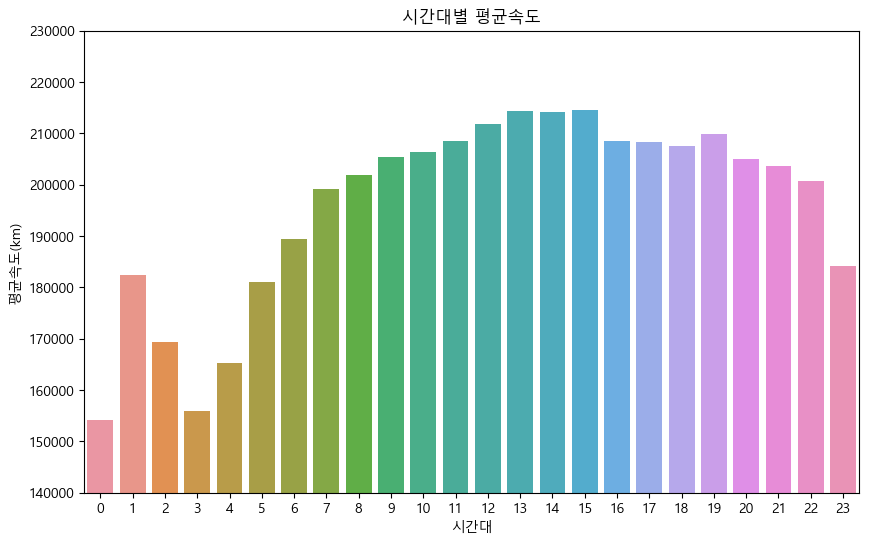

In [23]:
fig, timeplot = plt.subplots(figsize=(10, 6), dpi=100)
timeplot = sns.countplot(x='시간대', data=train)
timeplot.set_ylim(bottom=100000, top=250000)
timeplot.set_title("시간대별 교통량")

# 시간대별 평균속도값이 작은 순으로 정렬
train.groupby("시간대")["평균속도(km)"].count().sort_values(ascending=True)
train.groupby("시간대")["평균속도(km)"].value_counts(ascending=False)

for i in range(24):
    mean_time = train[train["시간대"] == i]["평균속도(km)"].mean()
    print("{}시의 평균 속도는 {:.3f} km 입니다.".format(i, mean_time))

# 시간대별 평균속도의 평균값을 작은 순으로 정렬
mean_speeds = train.groupby("시간대")["평균속도(km)"].mean().sort_values(ascending=True)

# 시간대별 평균속도 시각화
sns.barplot(x=train.시간대.unique(), y=train.groupby("시간대")["평균속도(km)"].mean())
plt.ylim(140000, 230000)  # Apply y-axis limits to the existing bar plot
plt.title("시간대별 평균속도")
plt.ylabel("평균속도(km)")
plt.xlabel("시간대")
plt.show()

## 추가 시각화

In [24]:
train.head()

,날짜,시간대,차로수,도로등급,중용구간 여부,연결로 코드,최고속도제한,통과제한차량,통과제한하중,통과제한높이,도로유형,평균속도(km),시작지점_위경도_벡터,도착지점_위경도_벡터,시작지점명_encoded,도착지점명_encoded,시작 지점의 회전제한 유무_encoded,도작지점의 회전제한 유무_encoded,요일_숫자형
0,20220623,17,1,106,0,0,60.0,0.0,32400.0,0.0,3,52.0,130.999357,130.999090,386,386,0,0,3
1,20220728,21,2,103,0,0,60.0,0.0,0.0,0.0,0,30.0,130.888937,130.887210,32,2,1,0,3
2,20211010,7,2,103,0,0,80.0,0.0,0.0,0.0,0,61.0,130.677175,130.671173,426,179,0,0,6
3,20220311,13,2,107,0,0,50.0,0.0,0.0,0.0,0,20.0,130.860839,130.859764,58,203,0,0,4
4,20211005,8,2,103,0,0,80.0,0.0,0.0,0.0,0,38.0,130.683271,130.686870,267,269,0,0,1


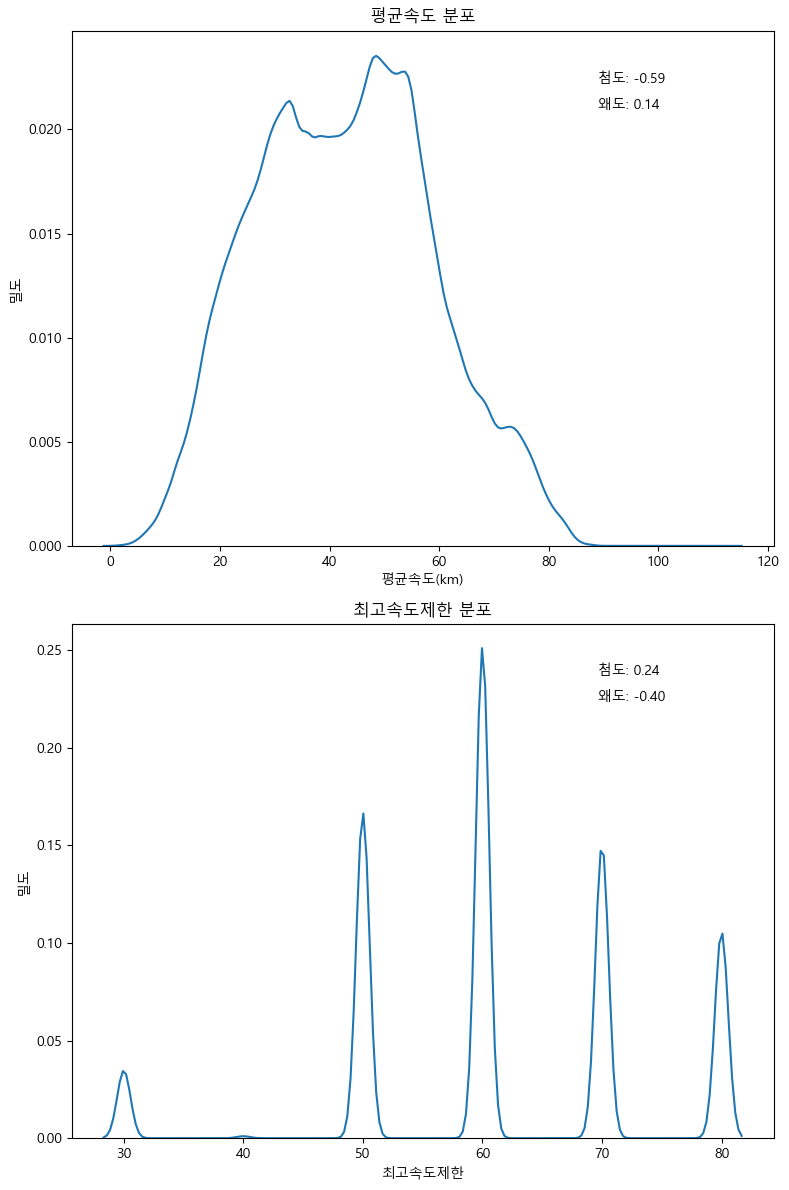

In [25]:
kurtosis_speed = kurtosis(train['평균속도(km)'])
skewness_speed = skew(train['평균속도(km)'])

kurtosis_limit = kurtosis(train['최고속도제한'])
skewness_limit = skew(train['최고속도제한'])

fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# Plot for '평균속도(km)'
sns.kdeplot(train['평균속도(km)'], ax=axes[0])
axes[0].set_title("평균속도 분포")
axes[0].set_xlabel("평균속도(km)")
axes[0].set_ylabel("밀도")
axes[0].text(0.75, 0.9, "첨도: {:.2f}".format(kurtosis_speed), transform=axes[0].transAxes)
axes[0].text(0.75, 0.85, "왜도: {:.2f}".format(skewness_speed), transform=axes[0].transAxes)

# Plot for '최고속도제한'
sns.kdeplot(train['최고속도제한'], ax=axes[1])
axes[1].set_title("최고속도제한 분포")
axes[1].set_xlabel("최고속도제한")
axes[1].set_ylabel("밀도")
axes[1].text(0.75, 0.9, "첨도: {:.2f}".format(kurtosis_limit), transform=axes[1].transAxes)
axes[1].text(0.75, 0.85, "왜도: {:.2f}".format(skewness_limit), transform=axes[1].transAxes)

plt.tight_layout()
plt.show()


* 

<AxesSubplot:xlabel='최고속도제한', ylabel='평균속도(km)'>

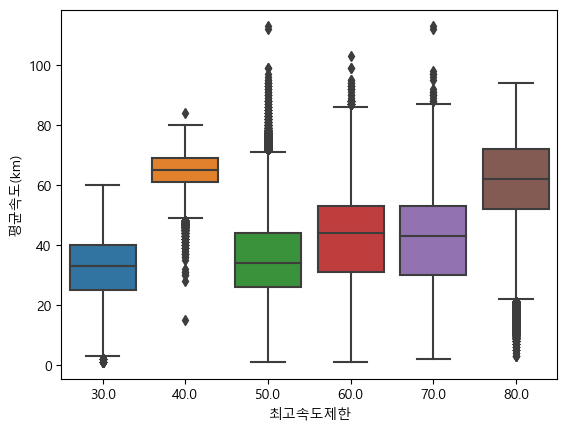

In [26]:
sns.boxplot(x = "최고속도제한", y = "평균속도(km)", data = train)

### 최대 제한 속도에 따라 평균 값의 차이가 다른 것이 확인된다.
### 이상치 중에서도 값의 차이가 많이 나는 값이 있다.
### 이를 극단치로 정의하고 제거하겠습니다

<AxesSubplot:xlabel='차로수', ylabel='평균속도(km)'>

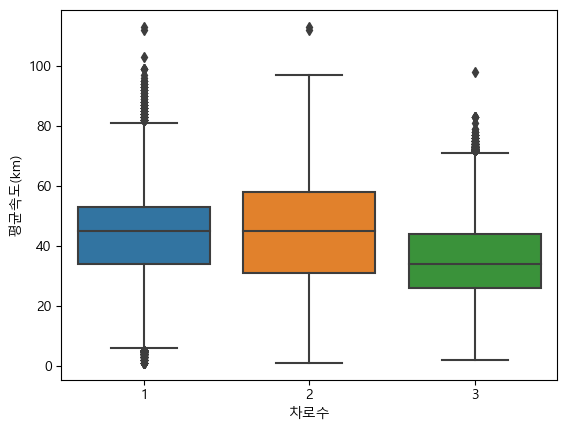

In [27]:
sns.boxplot(x = '차로수', y = '평균속도(km)', data = train)

In [28]:
train.groupby("차로수")["평균속도(km)"].mean()

차로수
1    43.570562
2    44.915713
3    34.917783
Name: 평균속도(km), dtype: float64

### 차선이 늘어날 수록 평균속도가 줄어든 모습이 보입니다
### 2 차선 일 때 가장 빠른 속도를 보였고, 3차선 일 때 가장 느린 속도를 보였습니다.
### 3차선일 때 평균속도가 유의미하게 차이가 나는 것이 확인되므로 학습에 활용할 수 있습니다.

In [32]:
#극단치 제거

train = train[train["평균속도(km)"]<100]

train_x = train.drop(columns=['평균속도(km)'])
train_y = train['평균속도(km)']
test_x = test

# 모델링

In [33]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.2,
                                                  random_state = 42)

In [34]:
xgb_model = xgb.XGBRegressor()  #**params 넣으면 오래걸려서 일단 스킵
xgb = xgb_model.fit(train_x,train_y)
print( '결정계수: ', xgb_model.score(train_x, train_y))

결정계수:  0.8869709679227413


In [21]:
xgb_model = xgb.XGBRegressor()

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# GridSearchCV를 사용하여 최적의 파라미터 값을 찾습니다.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=cv,
                          )
grid_search.fit(train_x, train_y)

# 최적의 파라미터와 점수 출력
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE score: ", np.sqrt(-grid_search.best_score_))

# 최적의 파라미터로 학습된 모델 사용
best_model = grid_search.best_estimator_

KeyboardInterrupt: 

In [36]:
# 가중치 부여

cmap = plt.get_cmap()
a = eli5.show_weights(xgb, feature_names = train_x.columns.tolist())

Weight,Feature
0.3172,최고속도제한
0.1850,도로등급
0.0896,연결로 코드
0.0858,통과제한하중
0.0608,차로수
0.0502,도착지점_위경도_벡터
0.0383,시작지점_위경도_벡터
0.0361,도로유형
0.0338,시작 지점의 회전제한 유무_encoded
0.0337,시작지점명_encoded
